Credit Card Approval Prediction System
WGU C964 Computer Science Capstone
Author: Blake Mancill

# =============================================================================
# SECTION 1: IMPORTS AND SETUP
# =============================================================================

In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
%matplotlib inline

# =============================================================================
# SECTION 2: DATA LOADING
# =============================================================================

In [153]:
print("\n📁 LOADING DATA...")

application_df = pd.read_csv("https://raw.githubusercontent.com/blakemancill/C964-Credit-Card-App/main/data/Credit_card.csv")
status_df = pd.read_csv("https://raw.githubusercontent.com/blakemancill/C964-Credit-Card-App/main/data/Credit_card_label.csv")

print(f"📊 Application Records: {application_df.shape[0]:,} rows, {application_df.shape[1]} columns")
print(f"📊 Credit Records: {status_df.shape[0]:,} rows, {status_df.shape[1]} columns")
print(f"👥 Unique Applicants in Application Data: {application_df['Ind_ID'].nunique():,}")
print(f"👥 Unique Applicants in Credit Data: {status_df['Ind_ID'].nunique():,}")


📁 LOADING DATA...
📊 Application Records: 1,548 rows, 18 columns
📊 Credit Records: 1,548 rows, 2 columns
👥 Unique Applicants in Application Data: 1,548
👥 Unique Applicants in Credit Data: 1,548


# =============================================================================
# SECTION 3: DESCRIPTIVE ANALYSIS
# =============================================================================


📊 DESCRIPTIVE ANALYSIS

Generating pie charts for credit records...


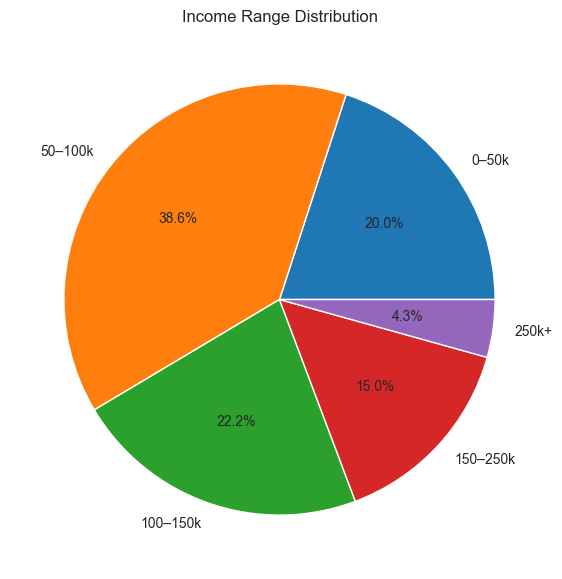

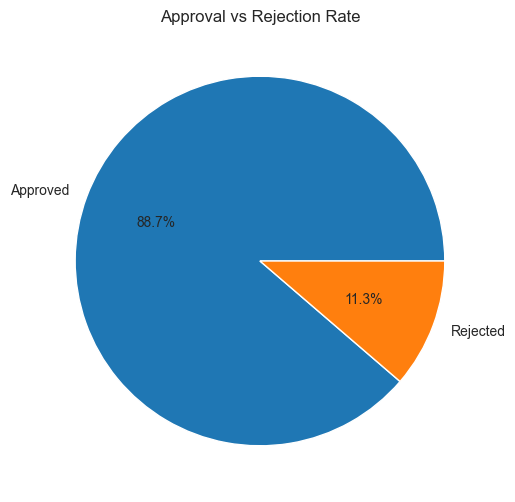

In [154]:
print("\n" + "=" * 60)
print("📊 DESCRIPTIVE ANALYSIS")
print("=" * 60)

print("\nGenerating pie charts for credit records...")

income_bins = pd.cut(
    application_df["Annual_income"] / application_df['Family_Members'].replace(0, 1),
    bins=[0, 50000, 100000, 150000, 250000, 1000000],
    labels=["0–50k", "50–100k", "100–150k", "150–250k", "250k+"]
)

plt.figure(figsize=(7,7))
income_bins.value_counts().sort_index().plot(
    kind='pie', autopct='%1.1f%%'
)
plt.title("Income Range Distribution")
plt.ylabel("")
plt.show()

merged = application_df.merge(status_df, on="Ind_ID", how="inner")

plt.figure(figsize=(6,6))

merged['label'].map({0: 'Approved', 1: 'Rejected'}).value_counts().plot(
    kind='pie', autopct='%1.1f%%'
)
plt.title("Approval vs Rejection Rate")
plt.ylabel("")
plt.show()

# =============================================================================
# SECTION 4: Data Merging
# =============================================================================

In [155]:
print("\n" + "=" * 60)
print("🔗 DATA MERGING")
print("=" * 60)

data = pd.merge(application_df, status_df, how='inner', on='Ind_ID')
print(f"✓ Merged dataset shape: {data.shape}")


🔗 DATA MERGING
✓ Merged dataset shape: (1548, 19)


# =============================================================================
# SECTION 5: FEATURE ENGINEERING
# =============================================================================

In [156]:
print("\n" + "=" * 60)
print("⚙️ FEATURE ENGINEERING")
print("=" * 60)

def engineer_features(df):
    """Create meaningful features from raw data."""
    df_eng = df.copy()

    # Age from birthday count
    df_eng['Age'] = (-df_eng['Birthday_count']) / 365.25

    # Has children or not
    df_eng['Has_Children'] = (df_eng['CHILDREN'] > 0).astype(int)

    # Employment status: positive value = unemployed
    df_eng['Is_Employed'] = (df_eng['Employed_days'] < 0).astype(int)

    # Years employed
    df_eng['Years_Employed'] = df_eng['Employed_days'].apply(
        lambda x: -x / 365.25 if x < 0 else 0
    )

    # Income per family member
    df_eng['Income_Per_Member'] = df_eng['Annual_income'] / df_eng['Family_Members'].replace(0, 1)

    # Asset score (car + property ownership)
    df_eng['Car_Owner_Binary'] = df_eng['Car_Owner'].map({'Y': 1, 'N': 0})
    df_eng['Property_Owner_Binary'] = df_eng['Propert_Owner'].map({'Y': 1, 'N': 0})
    df_eng['Gender_Binary'] = df_eng['GENDER'].map({'M': 1, 'F': 0})
    df_eng['Asset_Score'] = df_eng['Car_Owner_Binary'] + df_eng['Property_Owner_Binary']

    df_eng['Contact_Score'] = (
        df_eng['Mobile_phone'] +
        df_eng['Work_Phone'] +
        df_eng['Phone'] +
        df_eng['EMAIL_ID']
    )

    education_order = {
        'Lower secondary': 1,
        'Secondary / secondary special': 2,
        'Incomplete higher': 3,
        'Higher education': 4,
        'Academic degree': 5
    }
    df_eng['Education_Level'] = df_eng['EDUCATION'].map(education_order)

    categorical_cols = ['Type_Income', 'Marital_status', 'Housing_type', 'Type_Occupation']
    df_eng = pd.get_dummies(df_eng, columns=categorical_cols, drop_first=True)

    cols_to_drop = [
        'Ind_ID',           # Identifier
        'Annual_income',     # Replaced by income per member
        'Birthday_count',   # Replaced by Age
        'Employed_days',    # Replaced by Years_Employed
        'Car_Owner',        # Replaced by binary
        'Propert_Owner',    # Replaced by binary
        'GENDER',           # Replaced by binary
        'EDUCATION',        # Replaced by ordinal
    ]

    # Drop columns
    cols_to_drop = [c for c in cols_to_drop if c in df_eng.columns]
    df_eng = df_eng.drop(columns=cols_to_drop)

    return df_eng

data_engineered = engineer_features(data)

print(f"✓ Original features: {data.shape[1]}")
print(f"✓ Engineered features: {data_engineered.shape[1]}")
print(f"\n📋 New feature list:")
print(data_engineered.columns.tolist())


⚙️ FEATURE ENGINEERING
✓ Original features: 19
✓ Engineered features: 47

📋 New feature list:
['CHILDREN', 'Mobile_phone', 'Work_Phone', 'Phone', 'EMAIL_ID', 'Family_Members', 'label', 'Age', 'Has_Children', 'Is_Employed', 'Years_Employed', 'Income_Per_Member', 'Car_Owner_Binary', 'Property_Owner_Binary', 'Gender_Binary', 'Asset_Score', 'Contact_Score', 'Education_Level', 'Type_Income_Pensioner', 'Type_Income_State servant', 'Type_Income_Working', 'Marital_status_Married', 'Marital_status_Separated', 'Marital_status_Single / not married', 'Marital_status_Widow', 'Housing_type_House / apartment', 'Housing_type_Municipal apartment', 'Housing_type_Office apartment', 'Housing_type_Rented apartment', 'Housing_type_With parents', 'Type_Occupation_Cleaning staff', 'Type_Occupation_Cooking staff', 'Type_Occupation_Core staff', 'Type_Occupation_Drivers', 'Type_Occupation_HR staff', 'Type_Occupation_High skill tech staff', 'Type_Occupation_IT staff', 'Type_Occupation_Laborers', 'Type_Occupation

# =============================================================================
# SECTION 6: HANDLE MISSING VALUES
# =============================================================================

In [157]:
print("\n" + "=" * 60)
print("🧹 HANDLING MISSING VALUES")
print("=" * 60)

# Check what's missing'
print("\n📋 Missing values before imputation:")
print(data_engineered.isnull().sum()[data_engineered.isnull().sum() > 0])

# Income
if data_engineered['Income_Per_Member'].isnull().any():
    median_income = data_engineered['Income_Per_Member'].median()
    data_engineered['Income_Per_Member'] = data_engineered['Income_Per_Member'].fillna(median_income)
    print(f"✓ Income_Per_Member: filled with median (${median_income:,.0f})")

# Age - use median
if data_engineered['Age'].isnull().any():
    median_age = data_engineered['Age'].median()
    data_engineered['Age'] = data_engineered['Age'].fillna(median_age)
    print(f"✓ Age: filled with median ({median_age:.1f} years)")

# Gender_Binary - use mode (most frequent)
if data_engineered['Gender_Binary'].isnull().any():
    mode_gender = data_engineered['Gender_Binary'].mode()[0]
    data_engineered['Gender_Binary'] = data_engineered['Gender_Binary'].fillna(mode_gender)
    gender_label = 'Male' if mode_gender == 1 else 'Female'
    print(f"✓ Gender_Binary: filled with mode ({gender_label})")

# Handle any remaining occupation columns
occupation_cols = [col for col in data_engineered.columns if 'Type_Occupation' in col]
data_engineered[occupation_cols] = data_engineered[occupation_cols].fillna(0)

# Education_Level - fill with median
if data_engineered['Education_Level'].isnull().any():
    data_engineered['Education_Level'] = data_engineered['Education_Level'].fillna(
        data_engineered['Education_Level'].median()
    )
    print(f"✓ Education_Level: filled with median")

# Final verification
remaining_missing = data_engineered.isnull().sum().sum()
print(f"\n{'='*40}")
print(f"✓ Remaining missing values: {remaining_missing}")
print("✅ All missing values handled!")


🧹 HANDLING MISSING VALUES

📋 Missing values before imputation:
Age                  22
Income_Per_Member    23
Gender_Binary         7
dtype: int64
✓ Income_Per_Member: filled with median ($85,500)
✓ Age: filled with median (42.9 years)
✓ Gender_Binary: filled with mode (Female)

✓ Remaining missing values: 0
✅ All missing values handled!


# =============================================================================
# SECTION 7: TRAIN-TEST SPLIT
# =============================================================================

In [158]:
print("\n" + "=" * 60)
print("📦 PREPARING DATA FOR MODELING")
print("=" * 60)

X = data_engineered.drop(columns=['label'])
y = data_engineered['label']

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\n✓ Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.0f}%)")
print(f"✓ Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.0f}%)")



📦 PREPARING DATA FOR MODELING

✓ Training set: 1,238 samples (80%)
✓ Test set: 310 samples (20%)


# =============================================================================
# SECTION 8: Finding Optimal Threshold
# =============================================================================


🎯 FINDING OPTIMAL THRESHOLD

Threshold | Good Approved | Good Rejected | Bad Caught | Bad Missed | Net Value
-------------------------------------------------------------------------------------
  0.20    |        0      |      275      |     35     |      0     | $      0
  0.25    |       11      |      264      |     35     |      0     | $  5,500
  0.30    |       49      |      226      |     34     |      1     | $ 19,500
  0.35    |      104      |      171      |     33     |      2     | $ 42,000
  0.40    |      162      |      113      |     30     |      5     | $ 56,000
  0.45    |      199      |       76      |     28     |      7     | $ 64,500 ← BEST
  0.50    |      236      |       39      |     18     |     17     | $ 33,000

✓ Optimal Threshold: 0.45
✓ Max Net Value: $64,500
✓ Recall at Optimal: 80%


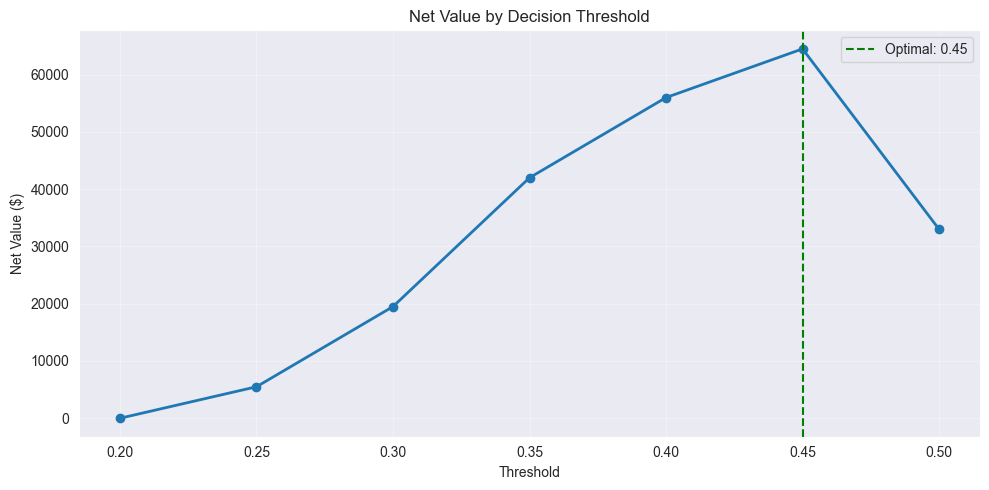

In [161]:
print("\n" + "=" * 60)
print("🎯 FINDING OPTIMAL THRESHOLD")
print("=" * 60)

PROFIT_GOOD = 500
LOSS_BAD = 5000

results = []

for thresh in np.arange(0.20, 0.55, 0.05):
    y_pred_temp = (y_prob >= thresh).astype(int)

    good_approved = ((y_test == 0) & (y_pred_temp == 0)).sum()
    good_rejected = ((y_test == 0) & (y_pred_temp == 1)).sum()
    bad_caught = ((y_test == 1) & (y_pred_temp == 1)).sum()
    bad_missed = ((y_test == 1) & (y_pred_temp == 0)).sum()

    net_value = (good_approved * PROFIT_GOOD) - (bad_missed * LOSS_BAD)

    results.append({
        'threshold': thresh,
        'good_approved': good_approved,
        'good_rejected': good_rejected,
        'bad_caught': bad_caught,
        'bad_missed': bad_missed,
        'recall': bad_caught / (bad_caught + bad_missed),
        'net_value': net_value
    })

results_df = pd.DataFrame(results)

# Find optimal
optimal = results_df.loc[results_df['net_value'].idxmax()]

print("\nThreshold | Good Approved | Good Rejected | Bad Caught | Bad Missed | Net Value")
print("-" * 85)
for _, row in results_df.iterrows():
    marker = " ← BEST" if row['threshold'] == optimal['threshold'] else ""
    print(f"  {row['threshold']:.2f}    |      {row['good_approved']:3.0f}      |      {row['good_rejected']:3.0f}      |     {row['bad_caught']:2.0f}     |     {row['bad_missed']:2.0f}     | ${row['net_value']:>7,.0f}{marker}")

print(f"\n✓ Optimal Threshold: {optimal['threshold']:.2f}")
print(f"✓ Max Net Value: ${optimal['net_value']:,.0f}")
print(f"✓ Recall at Optimal: {optimal['recall']:.0%}")

# Visualization
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(results_df['threshold'], results_df['net_value'], marker='o', linewidth=2)
ax.axvline(optimal['threshold'], color='green', linestyle='--', label=f"Optimal: {optimal['threshold']:.2f}")
ax.set_xlabel('Threshold')
ax.set_ylabel('Net Value ($)')
ax.set_title('Net Value by Decision Threshold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# SECTION 9: RANDOM FOREST MODEL
# =============================================================================


🌲 COST-SENSITIVE RANDOM FOREST CLASSIFIER
💰 Cost Ratio: 10:1 (bad customer costs 10x more than good customer profit)
Running grid search...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

✓ Best Parameters: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 300}
✓ Best CV Recall: 0.5143

📊 Results (threshold=0.45):
              precision    recall  f1-score   support

    Approved       0.97      0.72      0.83       275
    Rejected       0.27      0.80      0.40        35

    accuracy                           0.73       310
   macro avg       0.62      0.76      0.62       310
weighted avg       0.89      0.73      0.78       310

ROC-AUC Score: 0.7979
🎯 Bad Customers Caught: 28/35 (80%)
⚠️  Bad Customers Missed: 7/35


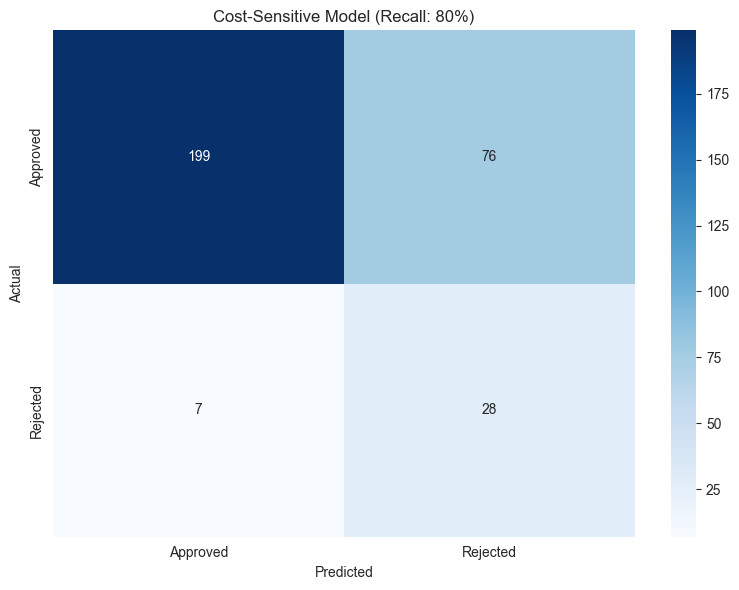

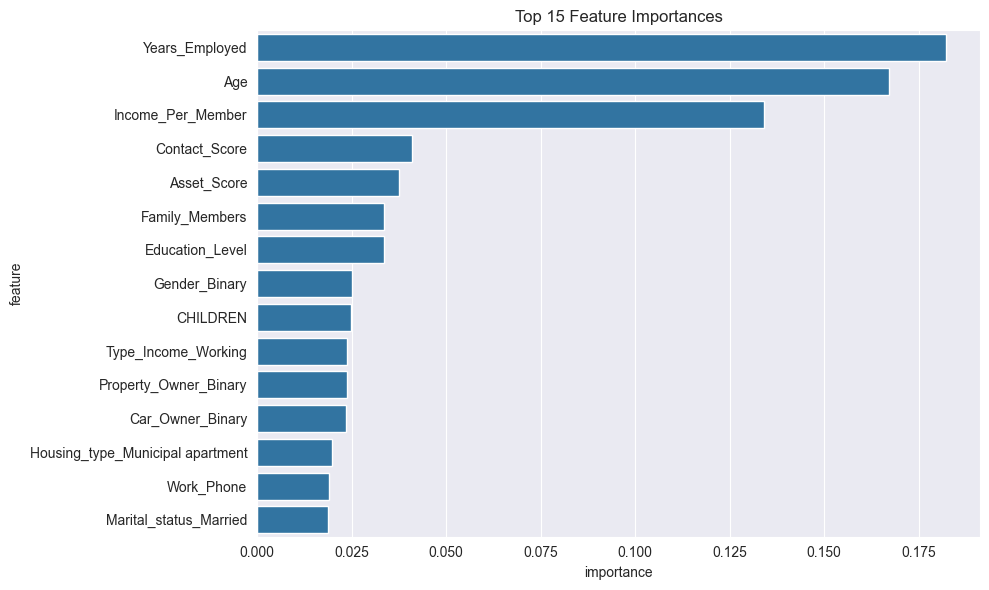


💵 COST-BENEFIT ANALYSIS:
   Good customers approved: 199 × $500 = $99,500
   Bad customers missed:    7 × $5,000 = -$35,000
   ─────────────────────────────────
   Net Value: $64,500


In [159]:
print("\n" + "=" * 60)
print("🌲 COST-SENSITIVE RANDOM FOREST CLASSIFIER")
print("=" * 60)

# Business logic: 1 default costs ~10x the profit from 1 good customer
COST_RATIO = 10

print(f"💰 Cost Ratio: {COST_RATIO}:1 (bad customer costs {COST_RATIO}x more than good customer profit)")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [3, 5, 10],
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight={0: 1, 1: COST_RATIO}  # Penalize missing rejections
    ),
    param_grid=param_grid,
    cv=5,
    scoring='recall',  # Optimize for catching bad customers
    n_jobs=-1,
    verbose=1
)

print("Running grid search...")
grid_search.fit(X_train, y_train)

print(f"\n✓ Best Parameters: {grid_search.best_params_}")
print(f"✓ Best CV Recall: {grid_search.best_score_:.4f}")

# Final model
best_rf = grid_search.best_estimator_
y_prob = best_rf.predict_proba(X_test)[:, 1]

# Lower threshold to catch more bad customers
DECISION_THRESHOLD = 0.45
y_pred = (y_prob >= DECISION_THRESHOLD).astype(int)

print(f"\n📊 Results (threshold={DECISION_THRESHOLD}):")
print(classification_report(y_test, y_pred, target_names=['Approved', 'Rejected']))

recall = recall_score(y_test, y_pred)
missed_bad = ((y_test == 1) & (y_pred == 0)).sum()
total_bad = (y_test == 1).sum()

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print(f"🎯 Bad Customers Caught: {total_bad - missed_bad}/{total_bad} ({recall:.0%})")
print(f"⚠️  Bad Customers Missed: {missed_bad}/{total_bad}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Approved', 'Rejected'],
    yticklabels=['Approved', 'Rejected']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Cost-Sensitive Model (Recall: {recall:.0%})')
plt.tight_layout()
plt.show()

# Feature Importance
feature_imp = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_imp, x='importance', y='feature')
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

# Cost-benefit analysis
PROFIT_GOOD = 500
LOSS_BAD = 5000

good_approved = ((y_test == 0) & (y_pred == 0)).sum()
good_rejected = ((y_test == 0) & (y_pred == 1)).sum()
bad_caught = ((y_test == 1) & (y_pred == 1)).sum()
bad_missed = ((y_test == 1) & (y_pred == 0)).sum()

net_value = (good_approved * PROFIT_GOOD) - (bad_missed * LOSS_BAD)

print(f"\n💵 COST-BENEFIT ANALYSIS:")
print(f"   Good customers approved: {good_approved} × ${PROFIT_GOOD:,} = ${good_approved * PROFIT_GOOD:,}")
print(f"   Bad customers missed:    {bad_missed} × ${LOSS_BAD:,} = -${bad_missed * LOSS_BAD:,}")
print(f"   ─────────────────────────────────")
print(f"   Net Value: ${net_value:,}")